In [1]:
import contextily
import pandas as pd
import geopandas as gpd
import requests
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

In [2]:
nyc_boundary_link='https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'
sectors_link="https://data.cityofnewyork.us/api/geospatial/eizi-ujye?method=export&format=GeoJSON"
precincts_link="https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=GeoJSON"

In [169]:
# get the response at the link
precincts = gpd.GeoDataFrame.from_features(requests.get(precincts_link).json())
sectors = gpd.GeoDataFrame.from_features(requests.get(sectors_link).json())

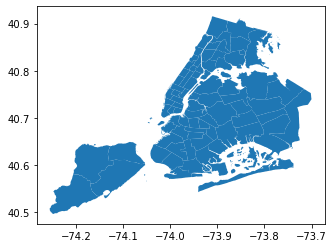

In [172]:
precincts.plot()

In [170]:
precincts.crs

In [173]:
# set coordiate reference system 
precincts.crs=from_epsg(4326) # this is the projection our data is in
precincts_mercator=precincts.to_crs(from_epsg(3857)) # this is the projection the tiles are in

/opt/anaconda3/envs/gep662/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [174]:
precincts_mercator['precinct']=precincts_mercator['precinct'].astype(str).str.zfill(3)

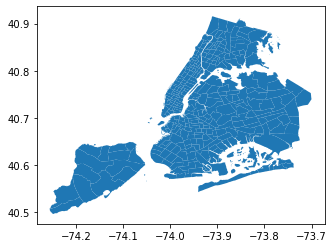

In [175]:
sectors.plot()

In [176]:
sectors.crs=from_epsg(4326) 
sectors_mercator=sectors.to_crs(from_epsg(3857))

/opt/anaconda3/envs/gep662/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [177]:
we, so, ea, no=precincts_mercator.total_bounds

In [178]:
contextily.providers['OpenStreetMap']['Mapnik']

{'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
 'max_zoom': 19,
 'attribution': '(C) OpenStreetMap contributors',
 'name': 'OpenStreetMap.Mapnik'}

In [179]:
img, ext = contextily.bounds2img(we, so, ea, no,
                                 10,# 19 is maximum zoom for this tiles
                         source=contextily.providers['OpenStreetMap']['Mapnik']['url'])

In [180]:
# rows, cols, number of bands (3: one for each R, G, and B)
img.shape

(512, 768, 3)

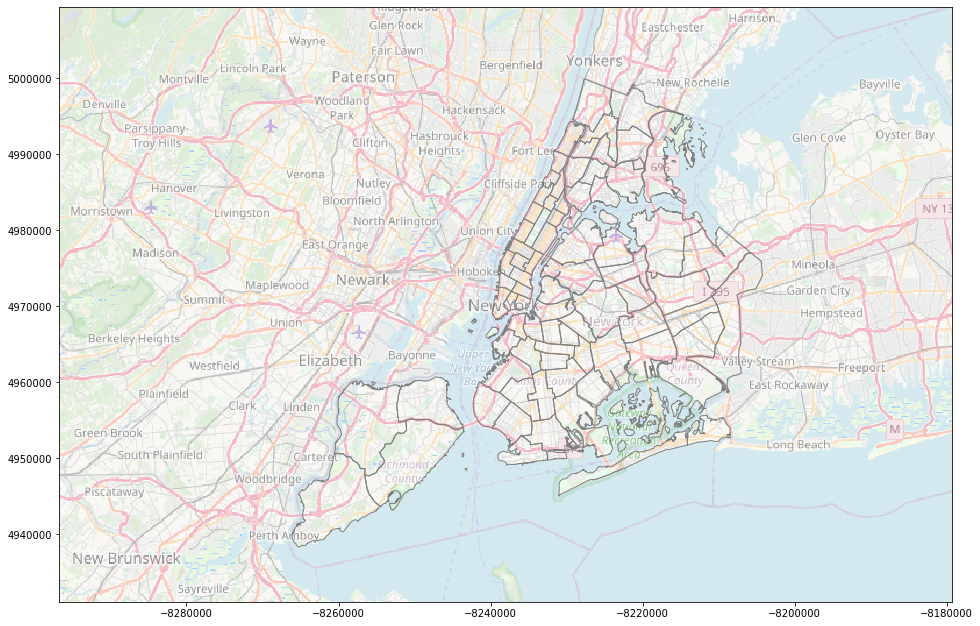

In [181]:
f, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img, extent=ext, alpha=0.5)
precincts_mercator.plot(ax=ax, color='None', edgecolor='grey', linewidth=1);

In [182]:
pct_boro=sectors.groupby('patrol_bor')['pct'].apply(lambda x: list(set(list(x)))).to_frame()

In [183]:
pct_boro.loc['PBBX'].pct

['042',
 '049',
 '052',
 '047',
 '040',
 '048',
 '045',
 '044',
 '050',
 '043',
 '046',
 '041']

# Download tiles for PBBX

In [188]:
bx_pcts=pct_boro.loc['PBBX'].pct

In [189]:
bronx=precincts_mercator.loc[precincts_mercator.precinct.isin(bx_pcts)]

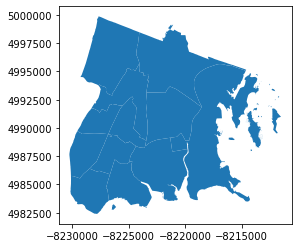

In [190]:
bronx.plot()

In [191]:
# get the coordinates of the bounding box--> this is the minimum square that can fit the spatial object inside
we, so, ea, no=bronx.total_bounds

In [193]:
# here are all tiles supported, there some that require API key
contextily.providers

{'OpenStreetMap': {'Mapnik': {'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.Mapnik'},
  'DE': {'url': 'https://{s}.tile.openstreetmap.de/tiles/osmde/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.DE'},
  'CH': {'url': 'https://tile.osm.ch/switzerland/{z}/{x}/{y}.png',
   'max_zoom': 18,
   'attribution': '(C) OpenStreetMap contributors',
   'bounds': [[45, 5], [48, 11]],
   'name': 'OpenStreetMap.CH'},
  'France': {'url': 'https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png',
   'max_zoom': 20,
   'attribution': '(C) Openstreetmap France | (C) OpenStreetMap contributors',
   'name': 'OpenStreetMap.France'},
  'HOT': {'url': 'https://{s}.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png',
   'max_zoom': 19,
   'attribution': '(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by 

In [213]:
# then just save it with bounds2raster()
for zoom_level in (13, 14, 15):
    img, ext = contextily.bounds2raster(we, so, ea, no, 
                                f'NYPD-Tiles/PBBX_z{zoom_level}.tif', 
                                zoom=zoom_level,
                                source=contextily.providers['OpenStreetMap']['Mapnik'],        
                               )

Check the saved tiles.

In [214]:
import rasterio

In [215]:
from rasterio.plot import reshape_as_image, plotting_extent

In [216]:
with rasterio.open('NYPD-Tiles/PBBX_z13.tif') as pbbx_src:
    pbbx=pbbx_src.read()

In [217]:
img=reshape_as_image(pbbx)

In [218]:
bx_precinct.bounds

,minx,miny,maxx,maxy
28,-8.227007e+06,4.982754e+06,-8.222961e+06,4.987214e+06


In [219]:
# this is same as toal bounds just reordered for plotting
ext=plotting_extent(pbbx_src)

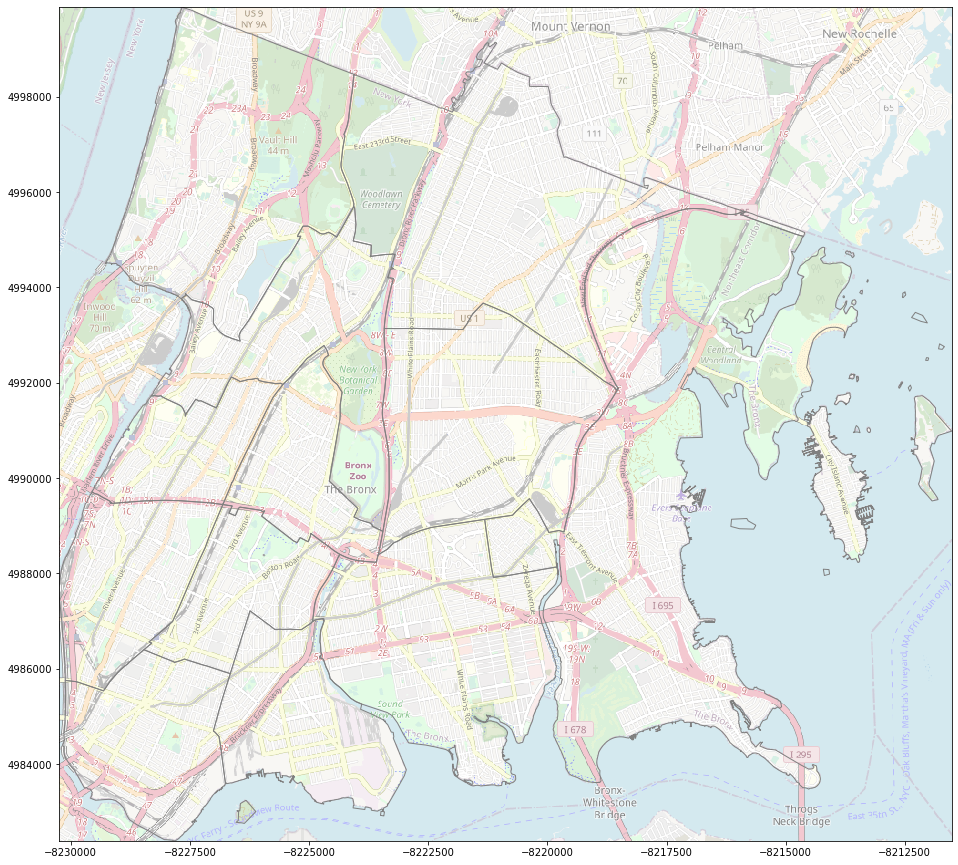

In [222]:
f, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img, extent=ext, alpha=0.5)
minx, miny, maxx, maxy=bronx.total_bounds
bronx.plot(ax=ax, color='None', edgecolor='grey', linewidth=1)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show();

In [ ]:
# Check one with higher zoom

In [224]:
for pct in pcts:
    bx_precinct=bronx.loc[bronx.precinct==pct]

In [225]:
bx_precinct

,geometry,precinct,shape_area,shape_leng
28,"MULTIPOLYGON (((-8226324.506 4983241.139, -822...",041,62139100.5382,47901.4225475


In [226]:
minx, miny, maxx, maxy=bx_precinct.total_bounds

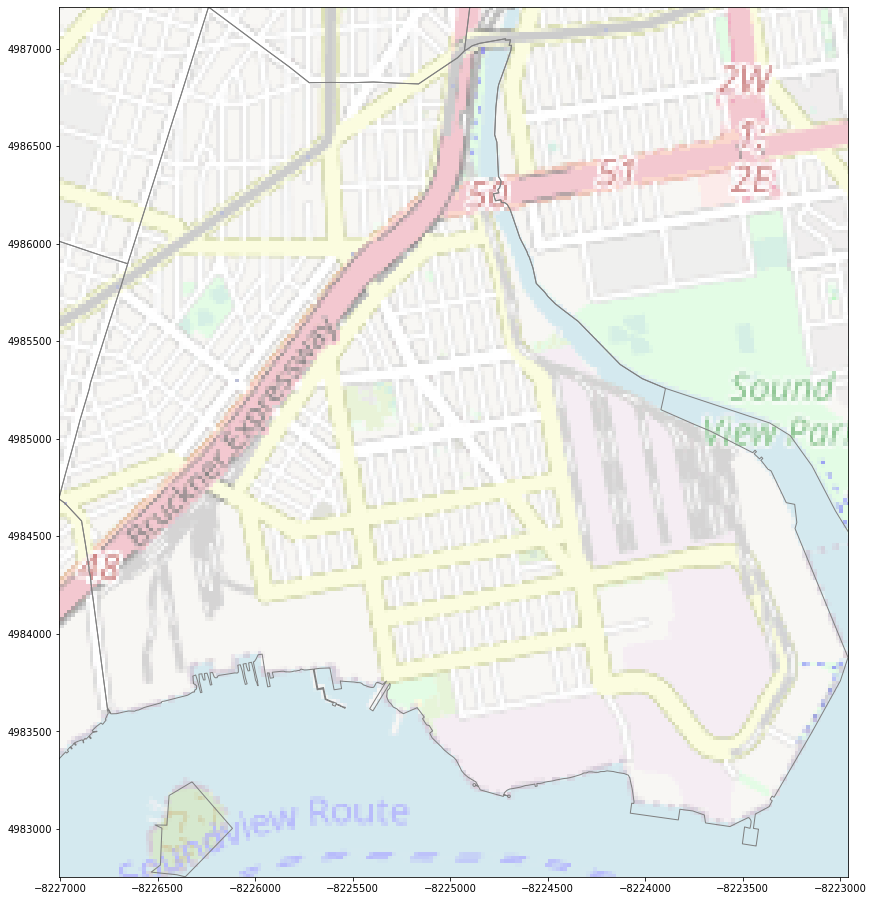

In [227]:
# see this is too coarse for preceint-level maps, higher zoom would look better
f, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img, extent=ext, alpha=0.5)
bronx.plot(ax=ax, color='None', edgecolor='grey', linewidth=1)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()

In [230]:
with rasterio.open('NYPD-Tiles/PBBX_z15.tif') as pbbx_src_15:
    pbbx_15=pbbx_src_15.read()

In [231]:
img_15=reshape_as_image(pbbx_15)

In [232]:
ext_15=plotting_extent(pbbx_src_15)

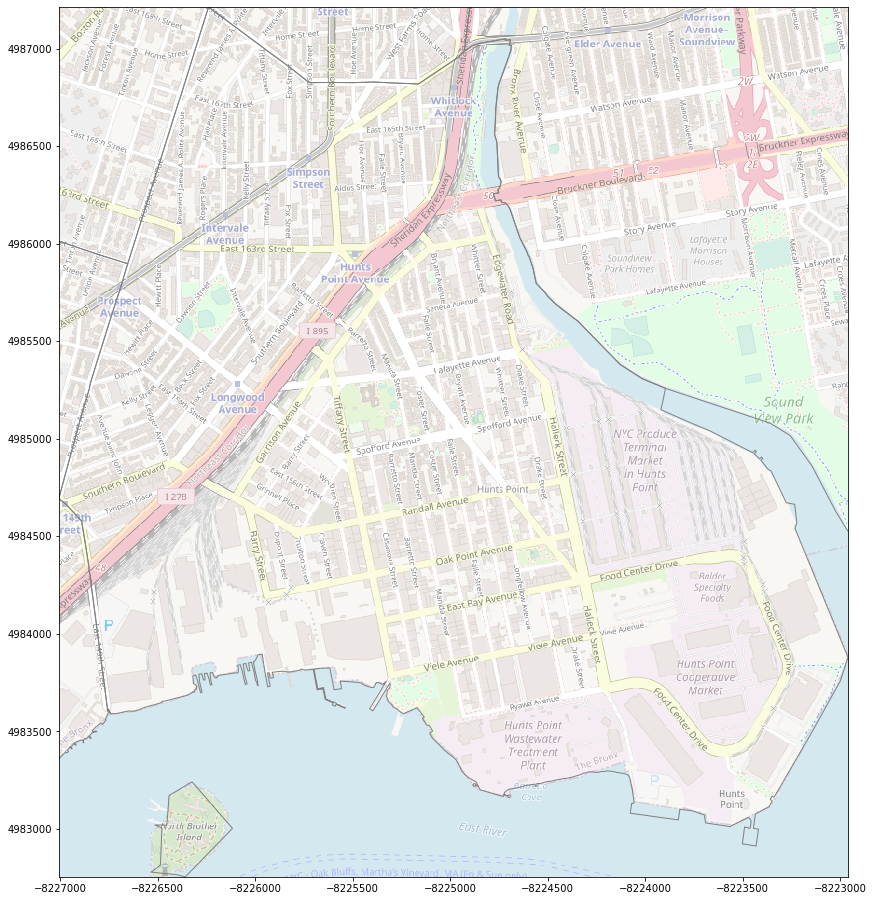

In [233]:
f, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img_15, extent=ext_15, alpha=0.5)
bronx.plot(ax=ax, color='None', edgecolor='grey', linewidth=1)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()